# RAM Analysis Notebook

This notebook is primarily to see the extent of how our RAM tags affect the InternVL model. We will see how the number of tags affects the model as well as how incorrect tags affect the model

## Load Libraries and Model

In [2]:
import os
import json
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

/home/fortemir/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "OpenGVLab/InternVL2-4B"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

/home/fortemir/anaconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[2024-12-04 17:49:27,301] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


FlashAttention2 is not installed.


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]
/home/fortemir/anaconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = image_file
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [5]:
#loading either hallusionbench or POPE
def generate_response(question, image):
    """ Prompt model with question regarding image and generate response.
    Args:
        question (str): question regarding the image content
        image_path (str): PIL image object
    
    Returns:
        response (str): model's response to the question
    """
    if image:
        pixel_values = load_image(image, max_num=12).to(torch.bfloat16).cuda() 
    generation_config = dict(max_new_tokens=1024, do_sample=True, max_time=90)
    response, _ = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
    
    return response

In [6]:
# Load POPE benchmark dataset
dataset = load_dataset("lmms-lab/POPE", "default")
dataset = dataset['test'].filter(lambda x: x['category'] == 'adversarial')

tags_path =  "../../models/recognize-anything/pope_tags.json"
dataset

Dataset({
    features: ['id', 'question_id', 'question', 'answer', 'image_source', 'image', 'category'],
    num_rows: 3000
})

In [7]:
def tags_to_dict(filepath):
    """
    Access RAM tags from json file and convert to dictionary.
    """
    filepath = filepath
    ram_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip().rstrip(",")
    
            data_entry = json.loads(line)
    
            ram_data.update(data_entry)
    return ram_data

ram_data = tags_to_dict(tags_path)

In [31]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.9 MB/s eta 0:00:00ta 0:00:01


## Testing model on different numbers of used RAM Tags

For this experiment, I will be testing to see if the # of RAM tags would affect the model accuracy. I made it so that the RAM tags are sorted by similarity with the desired object. So words very similar to the desired object are first in the list. This is to remove the alphabetical bias in the RAM tags since objects with earlier letters would be detected earlier. I then ran through the first 100 tests in POPE with differing amounts of distribution from 0 - 1. This is basically the percentage/portion of the RAM tags I would use for the prompt to the LVLM. So for example, a distribution of 0.5 would be to first use the first half of the RAM tags. The point is to test how impactful RAM tags are as they go from very important to irrelevant. Would they negatively impact the model due to the extraneous information, or would it not matter.

In [38]:
import math
import Levenshtein
def obtain_attributes(img_src, tag_proportion = 1.0, desired_word = "" ):
    """
    Returns the attributes identified by RAM.
    """
    if( tag_proportion == 0 ):
        return ""
        
    image_attrs = ram_data[img_src]
    image_attrs = image_attrs.replace('|',' ').split()
    injection = "This image has these attributes: "

    # Since distributions are sorted alphabetically, we want the correct object to be in the distribution and then see how additional unrelated tags impacts the model
    # So we use Levenshtein distance to sort the tags from most similar to least similar
    if( desired_word ):
        image_attrs = sorted(image_attrs, key=lambda word: Levenshtein.distance(word, desired_word))
        # print( image_attrs )

    num_tags = len( image_attrs )
    max_tags = math.ceil( tag_proportion * num_tags )
    
    for i in range(max_tags):
        if i == max_tags - 2:
            injection = injection + image_attrs[i]+", and "
        elif i == max_tags - 1:
            injection = injection + image_attrs[i] +"."
        else:
            injection = injection + image_attrs[i] + ", "
    return injection

In [9]:
import numpy as np

In [17]:
# Preload the data
pope_questions = dataset['question']
pope_images = dataset['image']
pope_img_source = dataset['image_source']

In [39]:
# We test to see how additional RAM tags besides the important ones impact the model's performance
# This code basically uses the first x% of the RAM tags and progresses from 0 - 100%.
# We also want the RAM tags to be sorted relative to the correct answer, to see how more unrelated objects impacts accuracy
# We do this via Levenshtein distance to see how similar 2 words are
# We are only going to go through 100 samples since computation is expensive and takes forever
distributions = np.linspace( 0, 1, 11 )
for distribution in distributions:
    internvl_pope_output_path = os.path.join(os.curdir, "RAM_Analysis_json/RAM_Analysis_2_" + str(distribution) + ".json")
    results = []
    for idx in range(100):
        question = pope_questions[idx]
        image = pope_images[idx]
        img_source = pope_img_source[idx]

        prompt = obtain_attributes( img_source, distribution, question.split( " " )[3] )
        prompt = f"{prompt} {question} Answer the question using a single word or phrase."
        response = generate_response(prompt, image)
        
        results.append( {"question": question, "answer": response} )
        
    with open(internvl_pope_output_path, 'w') as f:
        json.dump( results, f )
    
    print(f"InternVL's responses have been saved to {internvl_pope_output_path}")

InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.0.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.1.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.2.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.30000000000000004.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.4.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.5.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.6000000000000001.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.7000000000000001.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.8.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_0.9.json
InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_2_1.0.json


In [10]:
# Get the answers from POPE
pope_answers = np.array( dataset["answer"] )

In [100]:
from pathlib import Path
# Get the accuracy of each test
results = []
for results_file in Path("./RAM_Analysis_json/").glob("RAM_Analysis_2*.json"):

    # Read in each file
    fileName = str( results_file )
    with open(results_file, "r") as f:
        json_obj = json.load( f )

    distribution = fileName[-8:-5]

    # Get the model answers and the ground truths
    model_answers = np.array( ["yes" if "yes" in line["answer"].lower() else "no" for line in json_obj] )
    ground_truths = pope_answers

    # Get the counts
    TP, TN, FP, FN = 0, 0, 0, 0
    N = len( model_answers )
    positives = ["yes", "1"]
    for i in range( len( model_answers ) ):
        model_ans = model_answers[i]
        ground_truth = ground_truths[i]
        if( model_ans == ground_truth and model_ans in ["yes", "1"] ):
            TP += 1
        elif( model_ans == ground_truth and model_ans not in ["yes", "1"] ):
            TN += 1
        elif( model_ans != ground_truth and model_ans in ["yes", "1"] ):
            FP += 1
        else:
            FN += 1

    # Calculate the Metrics
    accuracy = ( TP + TN ) / N
    precision = TP / ( TP + FP )
    recall = TP / ( TP + FN )
    F1 = 2 * precision * recall / ( precision + recall )

    # Save the results
    results.append( [fileName, float( distribution ), accuracy, precision, recall, F1, [[TP,FP],[FN,TN]]] )

    # Print out the metrics
    print( fileName )
    print( f"Accuracy : {accuracy}" )
    print( f"Distribution : {distribution}" )
    print( f"Precision: {precision}" )
    print( f"Recall   : {recall}" )
    print( f"F1       : {F1}" )
    print( "-------------------------------------------------------" )

RAM_Analysis_json/RAM_Analysis_2_0.6.json
Accuracy : 0.74
Distribution : 0.6
Precision: 0.9
Recall   : 0.54
F1       : 0.675
-------------------------------------------------------
RAM_Analysis_json/RAM_Analysis_2_0.1.json
Accuracy : 0.62
Distribution : 0.1
Precision: 0.6578947368421053
Recall   : 0.5
F1       : 0.5681818181818182
-------------------------------------------------------
RAM_Analysis_json/RAM_Analysis_2_0.7.json
Accuracy : 0.77
Distribution : 0.7
Precision: 0.9090909090909091
Recall   : 0.6
F1       : 0.7228915662650602
-------------------------------------------------------
RAM_Analysis_json/RAM_Analysis_2_1.0.json
Accuracy : 0.76
Distribution : 1.0
Precision: 0.90625
Recall   : 0.58
F1       : 0.7073170731707317
-------------------------------------------------------
RAM_Analysis_json/RAM_Analysis_2_0.0.json
Accuracy : 0.48
Distribution : 0.0
Precision: 0.48148148148148145
Recall   : 0.52
F1       : 0.5
-------------------------------------------------------
RAM_Analys

In [101]:
import pandas as pd

# Get the dataframe
results_df = pd.DataFrame( results, columns = ["Test Case", "Distribution",  "Accuracy", "Precision", "Recall", "F1", "Values"] )
results_df.set_index( "Test Case", inplace = True )
results_df

,Distribution,Accuracy,Precision,Recall,F1,Values
Test Case,,,,,,
RAM_Analysis_json/RAM_Analysis_2_0.6.json,0.6,0.74,0.900000,0.54,0.675000,"[[27, 3], [23, 47]]"
RAM_Analysis_json/RAM_Analysis_2_0.1.json,0.1,0.62,0.657895,0.50,0.568182,"[[25, 13], [25, 37]]"
RAM_Analysis_json/RAM_Analysis_2_0.7.json,0.7,0.77,0.909091,0.60,0.722892,"[[30, 3], [20, 47]]"
RAM_Analysis_json/RAM_Analysis_2_1.0.json,1.0,0.76,0.906250,0.58,0.707317,"[[29, 3], [21, 47]]"
RAM_Analysis_json/RAM_Analysis_2_0.0.json,0.0,0.48,0.481481,0.52,0.500000,"[[26, 28], [24, 22]]"
RAM_Analysis_json/RAM_Analysis_2_0.5.json,0.5,0.81,0.969697,0.64,0.771084,"[[32, 1], [18, 49]]"
RAM_Analysis_json/RAM_Analysis_2_0.2.json,0.2,0.76,0.861111,0.62,0.720930,"[[31, 5], [19, 45]]"
RAM_Analysis_json/RAM_Analysis_2_0.8.json,0.8,0.76,0.882353,0.60,0.714286,"[[30, 4], [20, 46]]"
RAM_Analysis_json/RAM_Analysis_2_0.4.json,0.4,0.72,0.805556,0.58,0.674419,"[[29, 7], [21, 43]]"


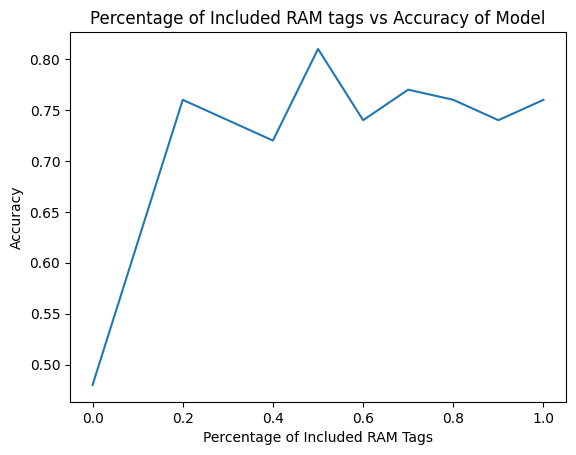

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Plot out the results
sns.lineplot( results_df, x = "Distribution", y = "Accuracy" )
plt.xlabel( "Percentage of Included RAM Tags" )
plt.title( "Percentage of Included RAM tags vs Accuracy of Model" )
plt.show()

As we can see, the accuracy doesn't change much once the RAM tags include the desired object. It can fluctuate a bit, but adding other RAM tags does not negatively/postively affect the model performance that much.

## Test incorrect RAM tags

For this part, we'll go through the same 100 test cases again. But this time, we'll use completely incorrect RAM tags. This is to see if and how much the RAM tags affect the LVLM when incorrectly measured.

In [58]:
# See how incorrect RAM tags impacts model accuracy
# We'll just use ram tags from the last 100 test cases instead of the first 100 test cases
internvl_pope_output_path = os.path.join(os.curdir, "RAM_Analysis_json/RAM_Analysis_Incorrect_RAM.json" )
results = []
for idx in range(100):
    question = pope_questions[idx]
    image = pope_images[idx]
    img_source = pope_img_source[-idx]

    prompt = obtain_attributes( img_source )
    prompt = f"{prompt} {question} Answer the question using a single word or phrase."
    response = generate_response(prompt, image)
    
    results.append( {"question": question, "answer": response} )
    
with open(internvl_pope_output_path, 'w') as f:
    json.dump( results, f )

print(f"InternVL's responses have been saved to {internvl_pope_output_path}")

InternVL's responses have been saved to ./RAM_Analysis_json/RAM_Analysis_Incorrect_RAM.json


In [103]:
# We want to compare this with no RAM tags (distribution = 0) and with RAM tags (distribution = 1)
from pathlib import Path
# Get the accuracy of each test
results = []
files = ["./RAM_Analysis_json/RAM_Analysis_2_0.0.json", "./RAM_Analysis_json/RAM_Analysis_2_1.0.json", "./RAM_Analysis_json/RAM_Analysis_Incorrect_RAM.json"]
titles = ["No RAM tags", "All RAM tags", "Incorrect RAM tags"]
for ind, results_file in enumerate( files ):

    # Read in each file
    fileName = str( results_file )
    with open(results_file, "r") as f:
        json_obj = json.load( f )

    # Get the model answers and the ground truths
    model_answers = np.array( ["yes" if "yes" in line["answer"].lower() else "no" for line in json_obj] )
    ground_truths = pope_answers

    # Get the counts
    TP, TN, FP, FN = 0, 0, 0, 0
    N = len( model_answers )
    positives = ["yes", "1"]
    for i in range( len( model_answers ) ):
        model_ans = model_answers[i]
        ground_truth = ground_truths[i]
        if( model_ans == ground_truth and model_ans in ["yes", "1"] ):
            TP += 1
        elif( model_ans == ground_truth and model_ans not in ["yes", "1"] ):
            TN += 1
        elif( model_ans != ground_truth and model_ans in ["yes", "1"] ):
            FP += 1
        else:
            FN += 1

    # Calculate the Metrics
    accuracy = ( TP + TN ) / N
    precision = TP / ( TP + FP )
    recall = TP / ( TP + FN )
    F1 = 2 * precision * recall / ( precision + recall )

    # Save the results
    results.append( [fileName, titles[ind], accuracy, precision, recall, F1, [[TP,FP],[FN,TN]]] )

    # Print out the metrics
    print( fileName )
    print( f"Accuracy : {accuracy}" )
    print( f"Distribution : {distribution}" )
    print( f"Precision: {precision}" )
    print( f"Recall   : {recall}" )
    print( f"F1       : {F1}" )
    print( "-------------------------------------------------------" )

./RAM_Analysis_json/RAM_Analysis_2_0.0.json
Accuracy : 0.48
Distribution : 0.9
Precision: 0.48148148148148145
Recall   : 0.52
F1       : 0.5
-------------------------------------------------------
./RAM_Analysis_json/RAM_Analysis_2_1.0.json
Accuracy : 0.76
Distribution : 0.9
Precision: 0.90625
Recall   : 0.58
F1       : 0.7073170731707317
-------------------------------------------------------
./RAM_Analysis_json/RAM_Analysis_Incorrect_RAM.json
Accuracy : 0.56
Distribution : 0.9
Precision: 0.7142857142857143
Recall   : 0.2
F1       : 0.3125
-------------------------------------------------------


In [104]:
# Turn the results into a dataframe
results_2_df = pd.DataFrame( results, columns = ["File Name", "Test Case",  "Accuracy", "Precision", "Recall", "F1", "Values"] )
results_2_df.set_index( "File Name", inplace = True )
results_2_df

,Test Case,Accuracy,Precision,Recall,F1,Values
File Name,,,,,,
./RAM_Analysis_json/RAM_Analysis_2_0.0.json,No RAM tags,0.48,0.481481,0.52,0.500000,"[[26, 28], [24, 22]]"
./RAM_Analysis_json/RAM_Analysis_2_1.0.json,All RAM tags,0.76,0.906250,0.58,0.707317,"[[29, 3], [21, 47]]"
./RAM_Analysis_json/RAM_Analysis_Incorrect_RAM.json,Incorrect RAM tags,0.56,0.714286,0.20,0.312500,"[[10, 4], [40, 46]]"


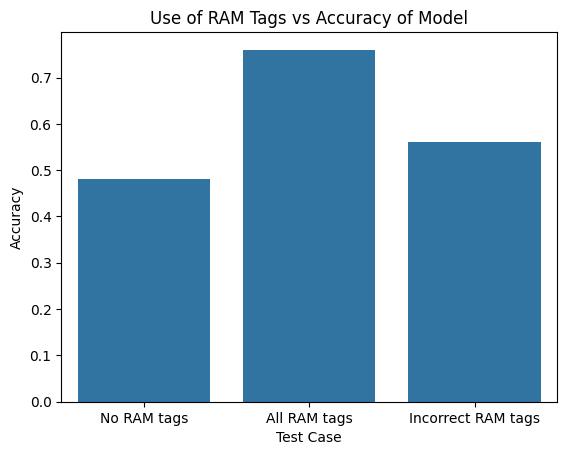

In [105]:
sns.barplot( results_2_df, x = "Test Case", y = "Accuracy" )
plt.title( "Use of RAM Tags vs Accuracy of Model" )
plt.show()

Interestingly, the incorrect RAM tags actually performs better than the RAM tags. Lets look a little deeper at the confusion matrices.

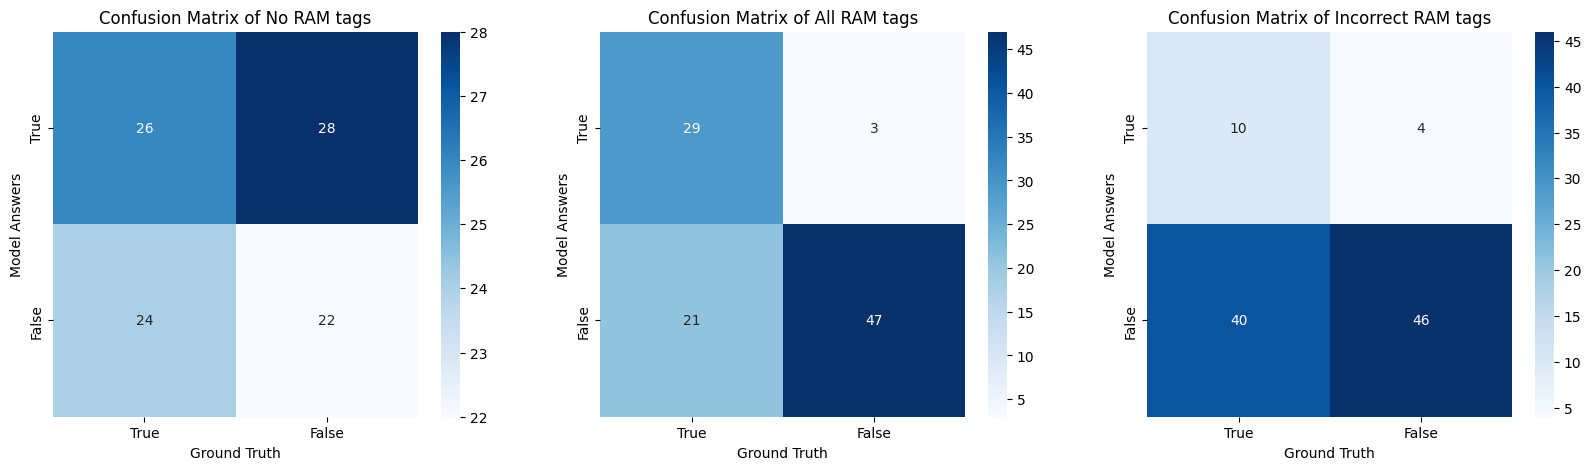

In [106]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5), dpi=100 )
for r in range( len( results_2_df ) ):
    sns.heatmap( results_2_df.iloc[r,:]["Values"], annot = True, fmt="1", cmap='Blues', xticklabels = ["True", "False"], yticklabels = ["True", "False"], ax = axs[r] )
    axs[r].set_xlabel( "Ground Truth" )
    axs[r].set_ylabel( "Model Answers" )
    axs[r].set_title( "Confusion Matrix of " + results_2_df.iloc[r]["Test Case"] )

plt.show()

As we can see, the model with incorrect RAM tags just outputs False most of the time. This is probably because it got confused by the prompt and picture and just returned false for everything. Thus, if our RAM tags are incorrect, the model becomes pretty cynical.

## Bonus Content/Scrapped Content

When I first did the first experiment, I didn't realize the RAM tags were alphabetically sorted. Thus, when the distribution became bigger, of course the accuracy would do better because more letters were included in the alphabet for the RAM tags and would include more desired objects in. So it basically didn't give any real insights on RAM tags and the model itself. As a result, I had to change my approach and distribute the RAM tags in a different manner.

In [110]:
from pathlib import Path
# Get the accuracy of each test
results_3 = []
for results_file in Path("./RAM_Analysis_json/").glob("RAM_Bad_Analysis_*.json"):

    # Read in each file
    fileName = str( results_file )
    with open(results_file, "r") as f:
        json_obj = json.load( f )

    distribution = fileName[-8:-5]

    # Get the model answers and the ground truths
    model_answers = np.array( ["yes" if "yes" in line["answer"].lower() else "no" for line in json_obj] )
    ground_truths = pope_answers

    # Get the counts
    TP, TN, FP, FN = 0, 0, 0, 0
    N = len( model_answers )
    positives = ["yes", "1"]
    for i in range( len( model_answers ) ):
        model_ans = model_answers[i]
        ground_truth = ground_truths[i]
        if( model_ans == ground_truth and model_ans in ["yes", "1"] ):
            TP += 1
        elif( model_ans == ground_truth and model_ans not in ["yes", "1"] ):
            TN += 1
        elif( model_ans != ground_truth and model_ans in ["yes", "1"] ):
            FP += 1
        else:
            FN += 1

    # Calculate the Metrics
    accuracy = ( TP + TN ) / N
    precision = TP / ( TP + FP )
    recall = TP / ( TP + FN )
    F1 = 2 * precision * recall / ( precision + recall )

    # Save the results
    results_3.append( [fileName, float( distribution ), accuracy, precision, recall, F1, [[TP,FP],[FN,TN]]] )

    # Print out the metrics
    print( fileName )
    print( f"Accuracy : {accuracy}" )
    print( f"Distribution : {distribution}" )
    print( f"Precision: {precision}" )
    print( f"Recall   : {recall}" )
    print( f"F1       : {F1}" )
    print( "-------------------------------------------------------" )

RAM_Analysis_json/RAM_Bad_Analysis_0.9.json
Accuracy : 0.76
Distribution : 0.9
Precision: 0.8823529411764706
Recall   : 0.6
F1       : 0.7142857142857143
-------------------------------------------------------
RAM_Analysis_json/RAM_Bad_Analysis_0.2.json
Accuracy : 0.58
Distribution : 0.2
Precision: 0.6818181818181818
Recall   : 0.3
F1       : 0.4166666666666667
-------------------------------------------------------
RAM_Analysis_json/RAM_Bad_Analysis_1.0.json
Accuracy : 0.76
Distribution : 1.0
Precision: 0.9642857142857143
Recall   : 0.54
F1       : 0.6923076923076923
-------------------------------------------------------
RAM_Analysis_json/RAM_Bad_Analysis_0.0.json
Accuracy : 0.51
Distribution : 0.0
Precision: 0.5098039215686274
Recall   : 0.52
F1       : 0.5148514851485149
-------------------------------------------------------
RAM_Analysis_json/RAM_Bad_Analysis_0.3.json
Accuracy : 0.59
Distribution : 0.3
Precision: 0.68
Recall   : 0.34
F1       : 0.4533333333333334
-----------------

In [111]:
results_3_df = pd.DataFrame( results_3, columns = ["File Name", "Distribution",  "Accuracy", "Precision", "Recall", "F1", "Values"] )
results_3_df.set_index( "File Name", inplace = True )
results_3_df

,Distribution,Accuracy,Precision,Recall,F1,Values
File Name,,,,,,
RAM_Analysis_json/RAM_Bad_Analysis_0.9.json,0.9,0.76,0.882353,0.60,0.714286,"[[30, 4], [20, 46]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.2.json,0.2,0.58,0.681818,0.30,0.416667,"[[15, 7], [35, 43]]"
RAM_Analysis_json/RAM_Bad_Analysis_1.0.json,1.0,0.76,0.964286,0.54,0.692308,"[[27, 1], [23, 49]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.0.json,0.0,0.51,0.509804,0.52,0.514851,"[[26, 25], [24, 25]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.3.json,0.3,0.59,0.680000,0.34,0.453333,"[[17, 8], [33, 42]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.5.json,0.5,0.68,0.821429,0.46,0.589744,"[[23, 5], [27, 45]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.1.json,0.1,0.63,0.782609,0.36,0.493151,"[[18, 5], [32, 45]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.7.json,0.7,0.71,0.888889,0.48,0.623377,"[[24, 3], [26, 47]]"
RAM_Analysis_json/RAM_Bad_Analysis_0.4.json,0.4,0.70,0.833333,0.50,0.625000,"[[25, 5], [25, 45]]"


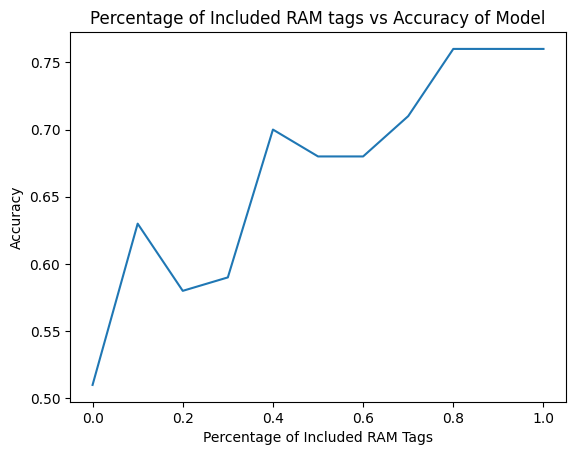

In [112]:
sns.lineplot( results_3_df, x = "Distribution", y = "Accuracy" )
plt.xlabel( "Percentage of Included RAM Tags" )
plt.title( "Percentage of Included RAM tags vs Accuracy of Model" )
plt.show()